## 🧠 MSLesSeg Dataset Overview

As part of this competition, participants were provided with the **MSLesSeg Dataset** — a **comprehensively annotated, multi-modal MRI dataset** designed for advancing **lesion segmentation** research in medical imaging.

### 📊 Dataset Composition
- **Total Patients:** 75 (48 women, 27 men)  
- **Age Range:** 18–59 years (Mean: 37 ± 10.3 years)  
- **Longitudinal Timepoints:**  
  - 50 patients with 1 timepoint  
  - 15 patients with 2 timepoints  
  - 5 patients with 3 timepoints  
  - 5 patients with 4 timepoints  
- **Time Interval Between Scans:** ~1.27 ± 0.62 years  
- **Total MRI Series:** 115

### 🧬 Imaging Modalities
Each timepoint includes **three core MRI modalities**:
- **T1-weighted (T1-w)**
- **T2-weighted (T2-w)**
- **FLAIR (Fluid-Attenuated Inversion Recovery)**

### 🧑‍⚕️ Expert Annotation
- Lesions were **manually annotated** by clinical experts.
- **FLAIR sequences** were the primary reference for lesion labeling.
- **T1-w and T2-w** scans supported **multi-contrast lesion characterization**.

### 🧪 Dataset Splits
- **Training Set:** 53 scans  
- **Test Set:** 22 scans  

### ✅ Ethical Compliance
- **Ethical approval** was obtained from the corresponding Hospital Ethics Committee.
- **Informed consent** was acquired from all participating patients.

---

# The Experiment

Below is the code used for the:

1) Preprocessing of the ***Brain MRI*** scans
2) Definition of Dataset, Dataloader and LihgtningDataModule classes
3) ***SegFormer3D*** architecture
4) ***PyTorch Lightning*** Trainer
5) Training & Evaluation
6) Model Exaplainability with the post-hoc method ***GradCam++***

---

## 🛠️ Preprocessing & Annotation Workflow

The MSLesSeg dataset underwent a **comprehensive preprocessing pipeline** and **expert-driven manual annotation** to ensure **standardization** and **label quality** for downstream MS lesion segmentation tasks.

### 🧼 Preprocessing Pipeline
1. **Anonymization** of all MRI scans to protect patient privacy.
2. **DICOM to NIfTI conversion**, leveraging NIfTI's wide adoption in neuroimaging.
3. **Co-registration to the MNI152 1mm³ isotropic template** using **FLIRT** (FMRIB’s Linear Image Registration Tool), ensuring all scans are aligned to a **common anatomical space**.
4. **Brain extraction** via **BET** (Brain Extraction Tool) to remove non-brain tissues and isolate relevant structures.

This pipeline guarantees that all images are **standardized** and **aligned**, which is critical for **automated MS lesion segmentation algorithms**.

---

### 🖋️ Ground-Truth Annotation Protocol
- Lesions were **manually segmented** on the **FLAIR modality** for each patient and timepoint.
- **T1-w and T2-w** modalities were used to **cross-validate ambiguous cases**.
- Annotation was conducted by a **trained junior rater**, under supervision of:
  - A **senior neuroradiologist**
  - A **senior neurologist**
- Annotation sessions included:
  - Multiple **training meetings** to establish a **consistent segmentation strategy**
  - Use of **JIM9** — a high-end tool for **medical image segmentation and analysis**
  - Regular **expert validation checkpoints** to ensure consistency and accuracy

The final masks, reviewed and approved by senior experts, are considered the **gold-standard ground truth**.

---

## 🧾 Key Annotation Highlights
- **Independent segmentation** for each patient/timepoint to avoid bias
- Conducted on **FLAIR scans registered to MNI space**
- **Validated ground-truth masks** ready for training and evaluation

---


# Visualizing the Brain MRI Scans

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

def load_nifti(file_path):
    nii = nib.load(file_path)
    return nii.get_fdata()

def get_middle_slice(volume):
    z = volume.shape[2] // 2
    return volume[:, :, z]

def plot_modalities_with_segmentation(flair_path, t1_path, t2_path, seg_path):
    # Load volumes
    flair = load_nifti(flair_path)
    t1 = load_nifti(t1_path)
    t2 = load_nifti(t2_path)
    seg = load_nifti(seg_path)

    # Normalize intensities for better visualization
    def normalize(img):
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        return img

    flair_norm = normalize(flair)
    t1_norm = normalize(t1)
    t2_norm = normalize(t2)

    # Get middle slices
    flair_slice = get_middle_slice(flair_norm)
    t1_slice = get_middle_slice(t1_norm)
    t2_slice = get_middle_slice(t2_norm)
    seg_slice = get_middle_slice(seg)

    modalities = [flair_slice, t1_slice, t2_slice]
    names = ["FLAIR", "T1", "T2"]

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    for i in range(3):
        # Row 1: original modality
        axs[0, i].imshow(modalities[i], cmap='gray')
        axs[0, i].set_title(f"{names[i]} - Middle Slice")
        axs[0, i].axis('off')

        # Row 2: overlay with segmentation mask
        axs[1, i].imshow(modalities[i], cmap='gray')
        axs[1, i].imshow(seg_slice, cmap='Reds', alpha=0.4)  # overlay
        axs[1, i].set_title(f"{names[i]} + Segmentation")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

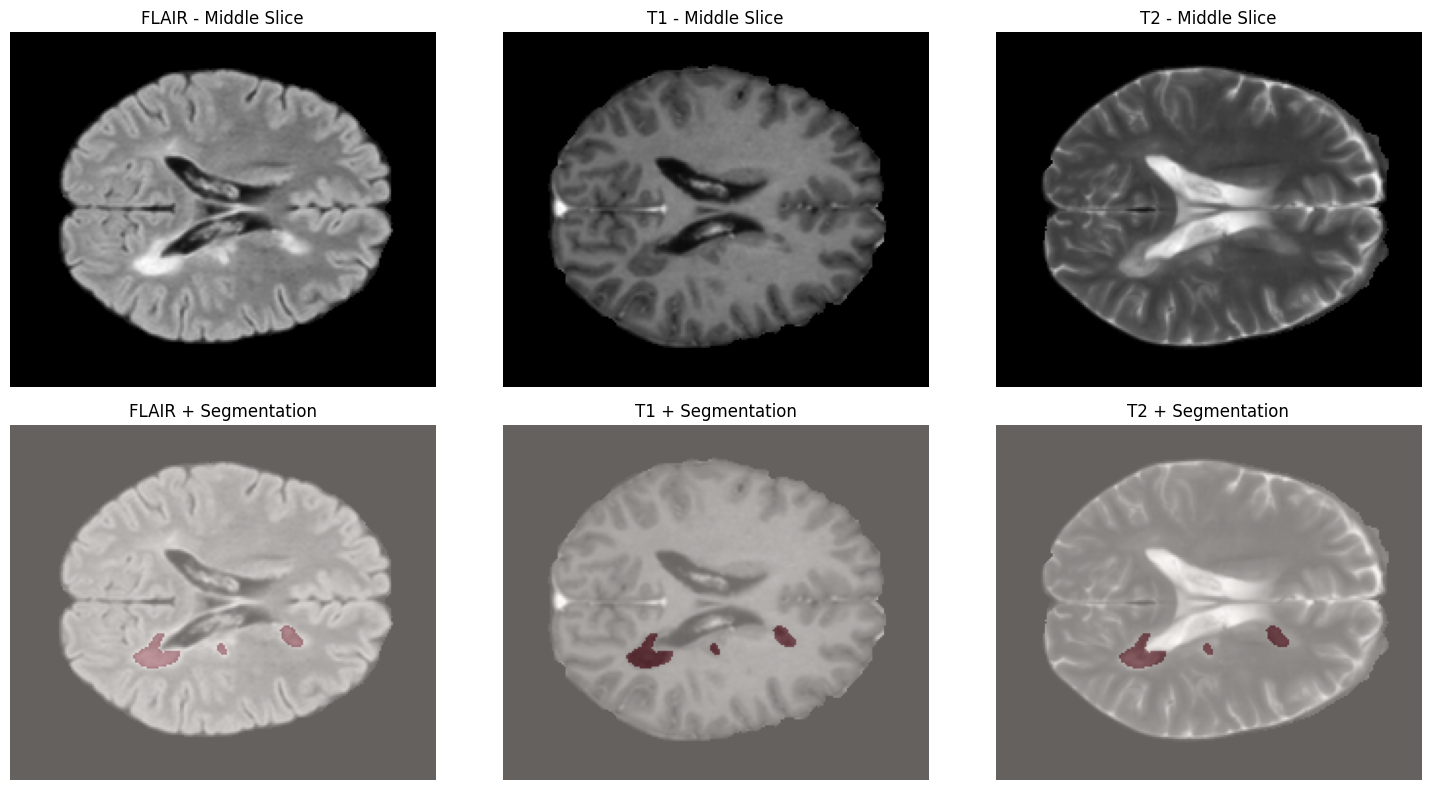

In [2]:
plot_modalities_with_segmentation(
    flair_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_flair.nii.gz",
    t1_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_t1.nii.gz",
    t2_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_t2.nii.gz",
    seg_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_seg.nii.gz"
)

---

As can be seen by the previous illustrations, the visualization of the data can be quite tricky, this is why developing reliable and high-quality ***Deep Learning*** architectures for ***Medical Imaging*** is paramount for the progress of the field in the medical realm

---

The following code shows all the details stored in the ***.nii.gz*** files of the ***Brain MRI*** scans

---

In [3]:
import nibabel as nib
import os
import numpy as np

def inspect_nifti_file(nii_path):
    if not os.path.exists(nii_path):
        print(f"File not found: {nii_path}")
        return

    img = nib.load(nii_path)
    data = img.get_fdata()
    affine = img.affine
    header = img.header

    print(f"Shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Voxel dimensions (zoom): {header.get_zooms()}")
    print(f"Affine matrix:\n{affine}")
    print(f"Min intensity: {np.min(data):.2f}")
    print(f"Max intensity: {np.max(data):.2f}")

In [4]:
for i in range(0, 10): 
    nii_path = f"../data/01-Pre-Processed-Data/train/MSLS_00{i}/MSLS_00{i}_flair.nii.gz"
    inspect_nifti_file(nii_path)
    print("\n\n\n")

Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 269.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 651.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 590.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity:

---

The following code shows that despite aligning the ***Brain MRI*** scans to the ***MNI152*** space with the ***FLIRT*** tool, they are physically stored in the ***LAS*** orientation

In order to guarantee compatibility with the model, and for better processing, they will be re-aligned to the ***RAS*** orientation

---

In [5]:
# Get the orientation codes of the Brain MRI data
import nibabel as nib
from nibabel.orientations import aff2axcodes

# Load your NIfTI file
img = nib.load("../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_flair.nii.gz")

# Get the affine matrix
affine = img.affine

# Get the orientation codes (e.g., RAS, LAS, LPI, etc.)
orientation = aff2axcodes(affine)

print(f"Image orientation: {orientation}")

Image orientation: ('L', 'A', 'S')


---

## Dataset Preprocessing

In this section we preprocess the data further in order to make it more ***friendly*** for the ***Deep Learning*** architecture to process, by applying:

1) ***Z-Scoring*** to align the intensity values of all scans
2) ***RAS re-orientation*** which is frequently used in ***Medical Imaging*** applications
3) ***Transverse Axis Swapping*** which is also commonly used in the same real of ***Computer Vision***

---

In [6]:
import os
import torch
import nibabel as nib
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.transform import resize
from pathlib import Path
from tqdm.notebook import tqdm

In [7]:
import numpy as np
import torch
import nibabel as nib
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from monai.data import MetaTensor
from monai.transforms import (
    Orientation, 
    EnsureType,
)

class Preprocessor:
    def __init__(self):
        pass

    def normalize(self, x: np.ndarray) -> np.ndarray:
        """
        Min-max normalization to [0, 1]
        This method reshapes the input array to 2D, applies normalization, and reshapes back.
        """
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Flatten the data to 2D (H*W*D, 1)
        original_shape = x.shape
        x_flat = x.reshape(-1, x.shape[-1])  # Reshape to (H*W*D, 1)
        
        # Apply normalization
        normalized_1D_array = scaler.fit_transform(x_flat)
        
        # Reshape back to the original data shape
        normalized_data = normalized_1D_array.reshape(original_shape)
        return normalized_data

    def load_nifti(self, filepath: Path):
        """ Load the .nii.gz file using nibabel and return the data and affine """
        img = nib.load(str(filepath))
        data = img.get_fdata()
        affine = img.affine
        return data, affine

    def preprocess_modality(self, data_fp: str, is_label: bool = False) -> np.ndarray:
        """
        Apply preprocess stage to the modality
        data_fp: directory to the modality
        is_label: whether it's a label (segmentation mask)
        """
        # Load data using nibabel
        data, affine = self.load_nifti(data_fp)

        # For labels (segmentation masks), do not normalize
        if is_label:
            # Binary mask does not need to be float64! For saving storage purposes!
            data = data.astype(np.uint8)

        else:
            # Normalize the image (for modalities like flair, t1, t2)
            data = self.normalize(data)

        
        # Add channel dimension (1, D, H, W)
        data = data[np.newaxis, ...]
        # For reorienting to RAS coordinate system, we need to apply affine matrix
        # Since we are now using nibabel, affine is already handled with the image
        data = MetaTensor(x=data, affine=affine)
        # For oreinting the coordinate system we need the affine matrix
        data = self.orient(data)
        # Detaching the meta values from the oriented array
        data = self.detach_meta(data)
        data = self.crop_centered_nonzero_region_swapped(data)

        return data

    def orient(self, x: MetaTensor) -> MetaTensor:
        # Orient the array to be in (Right, Anterior, Superior) scanner coordinate systems
        assert type(x) == MetaTensor
        return Orientation(axcodes="RAS")(x)

    def detach_meta(self, x: MetaTensor) -> np.ndarray:
        assert type(x) == MetaTensor
        return EnsureType(data_type="numpy", track_meta=False)(x)

    def crop_centered_nonzero_region_swapped(self, x, target_shape=(128, 128, 128)):
        """
        For input with shape (C, D, W, H), crop to target shape around non-zero region.
        """
        assert x.ndim == 4, f"Expected 4D input, got {x.shape}"
        c, d, w, h = x.shape
        td, tw, th = target_shape  # new order matches D, W, H
    
        # Union of non-zero across channels
        nonzero_mask = np.any(x > 0, axis=0)  # shape: (D, W, H)
        non_zero = np.array(np.where(nonzero_mask))  # indices for (D, W, H)
    
        if non_zero.shape[1] == 0:
            raise ValueError("Input appears to be all zeros.")
    
        # Min and max along each dimension
        min_d, max_d = np.min(non_zero[0]), np.max(non_zero[0])
        min_w, max_w = np.min(non_zero[1]), np.max(non_zero[1])
        min_h, max_h = np.min(non_zero[2]), np.max(non_zero[2])
    
        # Compute center
        center_d = (min_d + max_d) // 2
        center_w = (min_w + max_w) // 2
        center_h = (min_h + max_h) // 2
    
        def get_crop_bounds(center, size, max_dim):
            start = max(center - size // 2, 0)
            end = start + size
            if end > max_dim:
                end = max_dim
                start = max(end - size, 0)
            return start, end
    
        d_start, d_end = get_crop_bounds(center_d, td, d)
        w_start, w_end = get_crop_bounds(center_w, tw, w)
        h_start, h_end = get_crop_bounds(center_h, th, h)
    
        # Crop
        cropped = x[:, d_start:d_end, w_start:w_end, h_start:h_end]
    
        # Pad if needed
        pad_d = td - cropped.shape[1]
        pad_w = tw - cropped.shape[2]
        pad_h = th - cropped.shape[3]
    
        if pad_d > 0 or pad_w > 0 or pad_h > 0:
            padding = [
                (0, 0),  # channel dim
                (0, pad_d),
                (0, pad_w),
                (0, pad_h),
            ]
            cropped = np.pad(cropped, padding, mode='constant', constant_values=0)
    
        return cropped





    def preprocess_case(self, input_dir: Path, output_dir: Path, case_id: str):
        modalities = ['flair', 't1', 't2']
        stacked_modalities = []

        # Process each modality (flair, t1, t2)
        for mod in modalities:
            path = input_dir / f"{case_id}_{mod}.nii.gz"
            preprocessed = self.preprocess_modality(path, is_label=False)
            stacked_modalities.append(preprocessed)  # Collect modality data

        # Stack the modalities into a single tensor with shape (C, D, H, W)
        stacked_tensor = np.concatenate(stacked_modalities, axis=0)
        stacked_tensor.swapaxes(1, 3)
        input_tensor = torch.tensor(stacked_tensor, dtype=torch.float32)

        # Process the segmentation mask (label)
        seg_path = input_dir / f"{case_id}_seg.nii.gz"
        seg_data = self.preprocess_modality(seg_path, is_label=True)
        # Convert the segmentation mask into a PyTorch Tensor
        seg_data.swapaxes(1, 3)
        seg_tensor = torch.from_numpy(seg_data).type(torch.uint8)

        # Save the processed input and segmentation tensors
        output_case_dir = output_dir / case_id
        output_case_dir.mkdir(parents=True, exist_ok=True)
        torch.save(input_tensor, output_case_dir / "input_tensor.pt")
        torch.save(seg_tensor, output_case_dir / "seg_mask.pt")

In [8]:
# Define and instantiate the preprocessor class
pre = Preprocessor()

In [9]:
from pathlib import Path
from tqdm import tqdm

def run_preprocessing(root_path, output_path):
    input_path = Path(root_path)
    output_path = Path(output_path)

    # Get all case directories
    all_case_dirs = [d for d in input_path.iterdir() if d.is_dir()]
    print(f"Found {len(all_case_dirs)} cases.")

    for case_dir in tqdm(all_case_dirs):
        case_id = case_dir.name  # e.g., MSLS_000
        output_case_path = output_path / case_id  # Define output path for each case

        # Check if the case has already been processed (e.g., output directory or file exists)
        if output_case_path.exists():
            print(f"✅ Skipping {case_id}, already processed.")
            continue  # Skip processing if the case already exists

        try:
            pre.preprocess_case(case_dir, output_path, case_id)
        except Exception as e:
            print(f"❌ Failed on {case_id}: {e}")

In [10]:
# Run the preprocessing on the training set
RAW_DATA_PATH = "../data/01-Pre-Processed-Data/train"
OUTPUT_PATH = "../data/03-SegFormer-Tensor-Data/train"

run_preprocessing(RAW_DATA_PATH, OUTPUT_PATH)

Found 93 cases.


100%|███████████████████████████████████████████| 93/93 [01:14<00:00,  1.25it/s]


In [11]:
# Run the preprocessing on the test set
RAW_DATA_PATH = "../data/01-Pre-Processed-Data/test/test_MASK"
OUTPUT_PATH = "../data/03-SegFormer-Tensor-Data/test"

run_preprocessing(RAW_DATA_PATH, OUTPUT_PATH)

Found 22 cases.


100%|███████████████████████████████████████████| 22/22 [00:17<00:00,  1.25it/s]


In [12]:
import torch
import os
import numpy as np
from torch.serialization import add_safe_globals

def inspect_pt_file(pt_path):
    if not os.path.exists(pt_path):
        print(f"File not found: {pt_path}")
        return

    # If you trust the file, allow numpy reconstruct
    add_safe_globals([np.core.multiarray._reconstruct])

    # Load the file with weights_only=False
    data = torch.load(pt_path, weights_only=False)

    if isinstance(data, torch.Tensor):
        print(f"Tensor shape: {data.shape}")
        print(f"Tensor dtype: {data.dtype}")
    elif isinstance(data, dict):
        print("Loaded object is a dictionary.")
        for key, value in data.items():
            if isinstance(value, torch.Tensor):
                print(f"Key: {key}, Shape: {value.shape}, Dtype: {value.dtype}")
            else:
                print(f"Key: {key}, Type: {type(value)}")
    elif isinstance(data, np.ndarray):
        print(f"Loaded NumPy array with shape: {data.shape}, dtype: {data.dtype}")
    else:
        print(f"Loaded object is of type {type(data)}")

In [13]:
# Quickly inspect the preprocessed data to assess shape and type

In [14]:
pt_path = "../data/03-SegFormer-Tensor-Data/train/MSLS_000/input_tensor.pt"
inspect_pt_file(pt_path)

Tensor shape: torch.Size([3, 128, 128, 128])
Tensor dtype: torch.float32


In [15]:
pt_path = "../data/03-SegFormer-Tensor-Data/train/MSLS_000/seg_mask.pt"
inspect_pt_file(pt_path)

Tensor shape: torch.Size([1, 128, 128, 128])
Tensor dtype: torch.uint8


---

# Building the Dataset Class

---

In [16]:
# MSLesSeg Tensor Dataset class
import os
import glob
import torch
from torch.utils.data import Dataset

class MSLesSegDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.patient_dirs = self._get_patient_dirs()

    def _get_patient_dirs(self):
        """
        Helper function to search for all patient directories within train/test directories.
        """
        patient_dirs = []
        
        # Get all patient directories within the root_dir (either train or test)
        for patient_dir in os.listdir(self.root_dir):
            patient_path = os.path.join(self.root_dir, patient_dir)
            
            # Make sure it's a directory
            if os.path.isdir(patient_path):
                # Check if both 'input_tensor.pt' and 'seg_mask.pt' exist
                input_tensor_path = os.path.join(patient_path, 'input_tensor.pt')
                seg_mask_path = os.path.join(patient_path, 'seg_mask.pt')
                
                if os.path.exists(input_tensor_path) and os.path.exists(seg_mask_path):
                    patient_dirs.append(patient_path)
        
        return patient_dirs

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            dict: {'input': tensor, 'mask': tensor} for the requested sample.
        """
        patient_dir = self.patient_dirs[idx]
        
        # Load the input tensor and segmentation mask
        input_tensor = torch.load(os.path.join(patient_dir, 'input_tensor.pt'))  # Shape: [3, 182, 218, 182]
        seg_mask = torch.load(os.path.join(patient_dir, 'seg_mask.pt'))  # Shape: [1, 182, 218, 182]
        
        return input_tensor, seg_mask

---

# Building the PyTorch Lightning Data Module Class

---

In [17]:
# MSLesSeg (PyTorch) LightningDataModule definition
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

class MSLesSegDataModule(pl.LightningDataModule):
    
    def __init__(self, root_data_dir, batch_size, val_split, num_workers):
        """
        root_data_dir: Is the path to the train and test data
        """
        super().__init__()
        self.data_dir = root_data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Load full training dataset
        full_dataset = MSLesSegDataset(root_dir=os.path.join(self.data_dir, 'train'))

        # Split into train and val
        val_size = int(len(full_dataset) * self.val_split)
        train_size = len(full_dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(full_dataset, [train_size, val_size])

        # Load test dataset (if it exists)
        test_dir = os.path.join(self.data_dir, 'test')
        if os.path.exists(test_dir):
            self.test_dataset = MSLesSegDataset(root_dir=test_dir)
        else:
            self.test_dataset = None

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        if self.test_dataset:
            return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        return None



---

# Building the SegFormer3D Architecture

---

In [18]:
import math
import copy

from functools import partial
import torch
from torch import nn
from einops import rearrange


class SegFormer3D(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        sr_ratios: list = [4, 2, 1, 1],  # [2, 2, 1, 1] for potentially more accurate results
        embed_dims: list = [32, 64, 160, 256], # [64, 128, 320, 512] for a VERY aggressive model
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],  # [2, 2, 2, 2] for more detail
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [4, 4, 4, 4],  # Increase to experiment with efficiency if the GPU allows for it
        num_heads: list = [1, 2, 5, 8],  # Increase only as a last resort
        depths: list = [2, 2, 2, 2],  # Controls the depth of the model
        decoder_head_embedding_dim: int = 256, # 128 for a smaller model
        num_classes: int = 1,
        decoder_dropout: float = 0.0, # increase if overfitting is observed
    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratios: at which rate increases the projection dim of the hidden_state in the mlp
        num_heads: number of attention heads
        depths: number of attention layers
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channel of the network
        decoder_dropout: dropout rate of the concatenated feature maps

        """
        super().__init__()
        self.segformer_encoder = MixVisionTransformer(
            in_channels=in_channels,
            sr_ratios=sr_ratios,
            embed_dims=embed_dims,
            patch_kernel_size=patch_kernel_size,
            patch_stride=patch_stride,
            patch_padding=patch_padding,
            mlp_ratios=mlp_ratios,
            num_heads=num_heads,
            depths=depths,
        )
        # decoder takes in the feature maps in the reversed order
        reversed_embed_dims = embed_dims[::-1]
        self.segformer_decoder = SegFormerDecoderHead(
            input_feature_dims=reversed_embed_dims,
            decoder_head_embedding_dim=decoder_head_embedding_dim,
            num_classes=num_classes,
            dropout=decoder_dropout,
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Conv3d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()


    def forward(self, x):
        # embedding the input
        x = self.segformer_encoder(x)
        # # unpacking the embedded features generated by the transformer
        c1 = x[0]
        c2 = x[1]
        c3 = x[2]
        c4 = x[3]
        # decoding the embedded features
        x = self.segformer_decoder(c1, c2, c3, c4)


        return x
    
# ----------------------------------------------------- encoder -----------------------------------------------------
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channel: int = 4,
        embed_dim: int = 768,
        kernel_size: int = 7,
        stride: int = 4,
        padding: int = 3,
    ):
        """
        in_channels: number of the channels in the input volume
        embed_dim: embedding dimmesion of the patch
        """
        super().__init__()
        self.patch_embeddings = nn.Conv3d(
            in_channel,
            embed_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # standard embedding patch
        patches = self.patch_embeddings(x)
        patches = patches.flatten(2).transpose(1, 2)
        patches = self.norm(patches)
        return patches


class SelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        assert (
            embed_dim % num_heads == 0
        ), "Embedding dim should be divisible by number of heads!"

        self.num_heads = num_heads
        # embedding dimesion of each attention head
        self.attention_head_dim = embed_dim // num_heads

        # The same input is used to generate the query, key, and value,
        # (batch_size, num_patches, hidden_size) -> (batch_size, num_patches, attention_head_size)
        self.query = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.key_value = nn.Linear(embed_dim, 2 * embed_dim, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(proj_dropout)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv3d(
                embed_dim, embed_dim, kernel_size=sr_ratio, stride=sr_ratio
            )
            self.sr_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # (batch_size, num_patches, hidden_size)
        B, N, C = x.shape

        # (batch_size, num_head, sequence_length, embed_dim)
        q = (
            self.query(x)
            .reshape(B, N, self.num_heads, self.attention_head_dim)
            .permute(0, 2, 1, 3)
        )

        if self.sr_ratio > 1:
            n = cube_root(N)
            # (batch_size, sequence_length, embed_dim) -> (batch_size, embed_dim, patch_D, patch_H, patch_W)
            x_ = x.permute(0, 2, 1).reshape(B, C, n, n, n)
            # (batch_size, embed_dim, patch_D, patch_H, patch_W) -> (batch_size, embed_dim, patch_D/sr_ratio, patch_H/sr_ratio, patch_W/sr_ratio)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            # (batch_size, embed_dim, patch_D/sr_ratio, patch_H/sr_ratio, patch_W/sr_ratio) -> (batch_size, sequence_length, embed_dim)
            # normalizing the layer
            x_ = self.sr_norm(x_)
            # (batch_size, num_patches, hidden_size)
            kv = (
                self.key_value(x_)
                .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
                .permute(2, 0, 3, 1, 4)
            )
            # (2, batch_size, num_heads, num_sequence, attention_head_dim)
        else:
            # (batch_size, num_patches, hidden_size)
            kv = (
                self.key_value(x)
                .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
                .permute(2, 0, 3, 1, 4)
            )
            # (2, batch_size, num_heads, num_sequence, attention_head_dim)

        k, v = kv[0], kv[1]

        attention_score = (q @ k.transpose(-2, -1)) / math.sqrt(self.num_heads)
        attnention_prob = attention_score.softmax(dim=-1)
        attnention_prob = self.attn_dropout(attnention_prob)
        out = (attnention_prob @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_dropout(out)
        return out


class TransformerBlock(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        mlp_ratio: int = 2,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        mlp_ratio: at which rate increasse the projection dim of the embedded patch in the _MLP component
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            sr_ratio=sr_ratio,
            qkv_bias=qkv_bias,
            attn_dropout=attn_dropout,
            proj_dropout=proj_dropout,
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = _MLP(in_feature=embed_dim, mlp_ratio=mlp_ratio, dropout=0.0)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


class MixVisionTransformer(nn.Module):
    def __init__(
        self,
        in_channels: int = 4,
        sr_ratios: list = [8, 4, 2, 1],
        embed_dims: list = [64, 128, 320, 512],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [2, 2, 2, 2],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratio: at which rate increasse the projection dim of the hidden_state in the mlp
        num_heads: number of attenion heads
        depth: number of attention layers
        """
        super().__init__()

        # patch embedding at different Pyramid level
        self.embed_1 = PatchEmbedding(
            in_channel=in_channels,
            embed_dim=embed_dims[0],
            kernel_size=patch_kernel_size[0],
            stride=patch_stride[0],
            padding=patch_padding[0],
        )
        self.embed_2 = PatchEmbedding(
            in_channel=embed_dims[0],
            embed_dim=embed_dims[1],
            kernel_size=patch_kernel_size[1],
            stride=patch_stride[1],
            padding=patch_padding[1],
        )
        self.embed_3 = PatchEmbedding(
            in_channel=embed_dims[1],
            embed_dim=embed_dims[2],
            kernel_size=patch_kernel_size[2],
            stride=patch_stride[2],
            padding=patch_padding[2],
        )
        self.embed_4 = PatchEmbedding(
            in_channel=embed_dims[2],
            embed_dim=embed_dims[3],
            kernel_size=patch_kernel_size[3],
            stride=patch_stride[3],
            padding=patch_padding[3],
        )

        # block 1
        self.tf_block1 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[0],
                    num_heads=num_heads[0],
                    mlp_ratio=mlp_ratios[0],
                    sr_ratio=sr_ratios[0],
                    qkv_bias=True,
                )
                for _ in range(depths[0])
            ]
        )
        self.norm1 = nn.LayerNorm(embed_dims[0])

        # block 2
        self.tf_block2 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[1],
                    num_heads=num_heads[1],
                    mlp_ratio=mlp_ratios[1],
                    sr_ratio=sr_ratios[1],
                    qkv_bias=True,
                )
                for _ in range(depths[1])
            ]
        )
        self.norm2 = nn.LayerNorm(embed_dims[1])

        # block 3
        self.tf_block3 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[2],
                    num_heads=num_heads[2],
                    mlp_ratio=mlp_ratios[2],
                    sr_ratio=sr_ratios[2],
                    qkv_bias=True,
                )
                for _ in range(depths[2])
            ]
        )
        self.norm3 = nn.LayerNorm(embed_dims[2])

        # block 4
        self.tf_block4 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[3],
                    num_heads=num_heads[3],
                    mlp_ratio=mlp_ratios[3],
                    sr_ratio=sr_ratios[3],
                    qkv_bias=True,
                )
                for _ in range(depths[3])
            ]
        )
        self.norm4 = nn.LayerNorm(embed_dims[3])

    def forward(self, x):
        out = []
        # at each stage these are the following mappings:
        # (batch_size, num_patches, hidden_state)
        # (num_patches,) -> (D, H, W)
        # (batch_size, num_patches, hidden_state) -> (batch_size, hidden_state, D, H, W)

        # stage 1
        x = self.embed_1(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block1):
            x = blk(x)
        x = self.norm1(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 2
        x = self.embed_2(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block2):
            x = blk(x)
        x = self.norm2(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 3
        x = self.embed_3(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block3):
            x = blk(x)
        x = self.norm3(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 4
        x = self.embed_4(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block4):
            x = blk(x)
        x = self.norm4(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        return out


class _MLP(nn.Module):
    def __init__(self, in_feature, mlp_ratio=2, dropout=0.0):
        super().__init__()
        out_feature = mlp_ratio * in_feature
        self.fc1 = nn.Linear(in_feature, out_feature)
        self.dwconv = DWConv(dim=out_feature)
        self.fc2 = nn.Linear(out_feature, in_feature)
        self.act_fn = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.dwconv(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super().__init__()
        self.dwconv = nn.Conv3d(dim, dim, 3, 1, 1, bias=True, groups=dim)
        # added batchnorm (remove it ?)
        self.bn = nn.BatchNorm3d(dim)

    def forward(self, x):
        B, N, C = x.shape
        # (batch, patch_cube, hidden_size) -> (batch, hidden_size, D, H, W)
        # assuming D = H = W, i.e. cube root of the patch is an integer number!
        n = cube_root(N)
        x = x.transpose(1, 2).view(B, C, n, n, n)
        x = self.dwconv(x)
        # added batchnorm (remove it ?)
        x = self.bn(x)
        x = x.flatten(2).transpose(1, 2)

        return x



def cube_root(n):
    return round(math.pow(n, (1 / 3)))
    


# ----------------------------------------------------- decoder -------------------
class MLP_(nn.Module):
    """
    Linear Embedding
    """

    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.bn = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2).contiguous()
        x = self.proj(x)
        # added batchnorm (remove it ?)
        x = self.bn(x)
        return x



class SegFormerDecoderHead(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """

    def __init__(
        self,
        input_feature_dims: list = [512, 320, 128, 64],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 3,
        dropout: float = 0.0,
    ):
        """
        input_feature_dims: list of the output features channels generated by the transformer encoder
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channels
        dropout: dropout rate of the concatenated feature maps
        """
        super().__init__()
        self.linear_c4 = MLP_(
            input_dim=input_feature_dims[0],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c3 = MLP_(
            input_dim=input_feature_dims[1],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c2 = MLP_(
            input_dim=input_feature_dims[2],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c1 = MLP_(
            input_dim=input_feature_dims[3],
            embed_dim=decoder_head_embedding_dim,
        )
        # convolution module to combine feature maps generated by the mlps
        self.linear_fuse = nn.Sequential(
            nn.Conv3d(
                in_channels=4 * decoder_head_embedding_dim,
                out_channels=decoder_head_embedding_dim,
                kernel_size=1,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm3d(decoder_head_embedding_dim),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(dropout)

        # final linear projection layer
        self.linear_pred = nn.Conv3d(
            decoder_head_embedding_dim, num_classes, kernel_size=1
        )

        # segformer decoder generates the final decoded feature map size at 1/4 of the original input volume size
        self.upsample_volume = nn.Upsample(
            scale_factor=4.0, mode="trilinear", align_corners=False
        )

    def forward(self, c1, c2, c3, c4):
       ############## _MLP decoder on C1-C4 ###########
        n, _, _, _, _ = c4.shape

        _c4 = (
            self.linear_c4(c4)
            .permute(0, 2, 1)
            .reshape(n, -1, c4.shape[2], c4.shape[3], c4.shape[4])
            .contiguous()
        )
        _c4 = torch.nn.functional.interpolate(
            _c4,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c3 = (
            self.linear_c3(c3)
            .permute(0, 2, 1)
            .reshape(n, -1, c3.shape[2], c3.shape[3], c3.shape[4])
            .contiguous()
        )
        _c3 = torch.nn.functional.interpolate(
            _c3,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c2 = (
            self.linear_c2(c2)
            .permute(0, 2, 1)
            .reshape(n, -1, c2.shape[2], c2.shape[3], c2.shape[4])
            .contiguous()
        )
        _c2 = torch.nn.functional.interpolate(
            _c2,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c1 = (
            self.linear_c1(c1)
            .permute(0, 2, 1)
            .reshape(n, -1, c1.shape[2], c1.shape[3], c1.shape[4])
            .contiguous()
        )

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        x = self.dropout(_c)
        x = self.linear_pred(x)
        x = self.upsample_volume(x)
        return x


In [19]:
# Output a brief summary of the model
from torchinfo import summary

# Create the model instance
model = SegFormer3D(
    in_channels=3,
    sr_ratios=[4, 2, 1, 1],
    embed_dims=[32, 64, 160, 256],
    patch_kernel_size=[7, 3, 3, 3],
    patch_stride=[4, 2, 2, 2],
    patch_padding=[3, 1, 1, 1],
    mlp_ratios=[4, 4, 4, 4],
    num_heads=[1, 2, 5, 8],
    depths=[2, 2, 2, 2],
    decoder_head_embedding_dim=256,
    num_classes=1,
    decoder_dropout=0.0
)

# Move to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Show model summary
summary(model, input_size=(1, 3, 128, 128, 128), device=str(device))

Layer (type:depth-idx)                             Output Shape              Param #
SegFormer3D                                        [1, 1, 128, 128, 128]     --
├─MixVisionTransformer: 1-1                        [1, 32, 32, 32, 32]       --
│    └─PatchEmbedding: 2-1                         [1, 32768, 32]            --
│    │    └─Conv3d: 3-1                            [1, 32, 32, 32, 32]       32,960
│    │    └─LayerNorm: 3-2                         [1, 32768, 32]            64
│    └─ModuleList: 2-2                             --                        --
│    │    └─TransformerBlock: 3-3                  [1, 32768, 32]            82,176
│    │    └─TransformerBlock: 3-4                  [1, 32768, 32]            82,176
│    └─LayerNorm: 2-3                              [1, 32768, 32]            64
│    └─PatchEmbedding: 2-4                         [1, 4096, 64]             --
│    │    └─Conv3d: 3-5                            [1, 64, 16, 16, 16]       55,360
│    │    └─LayerNo

In [20]:
import torch

# Load the tensor (assuming it's a 4D tensor: [C, H, D, W] where C=3, H=height, D=depth, W=width)
tensor = torch.load('../data/03-SegFormer-Tensor-Data/train/MSLS_000/input_tensor.pt')
print(f"Shape of tensor: {tensor.shape}")  # Should output something like (3, 192, 192, 224)

Shape of tensor: torch.Size([3, 128, 128, 128])


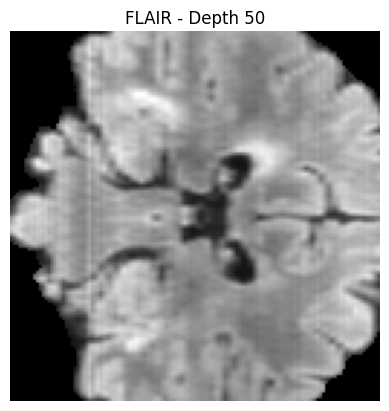

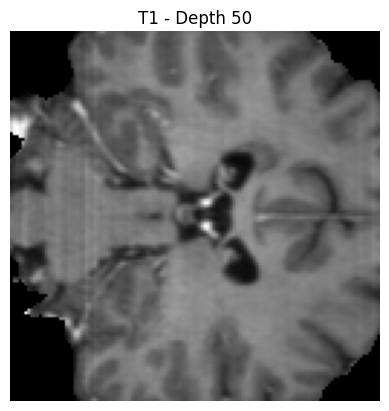

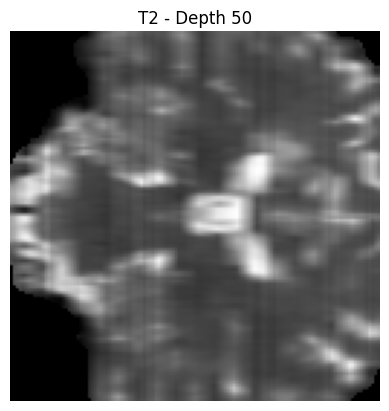

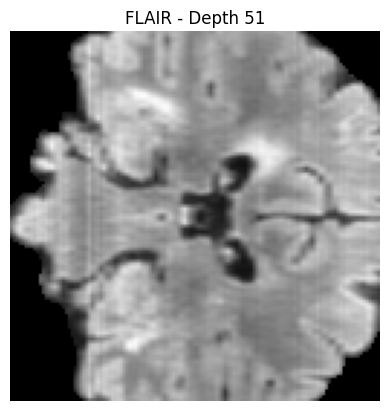

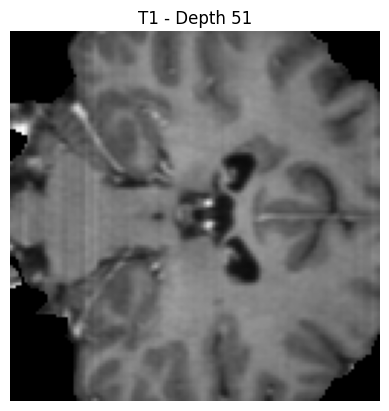

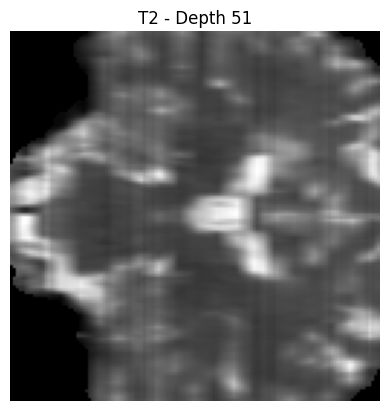

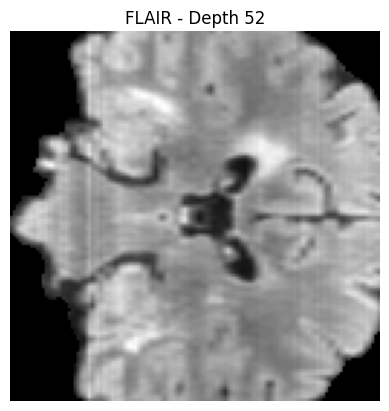

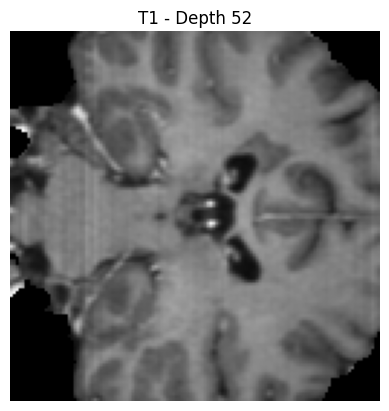

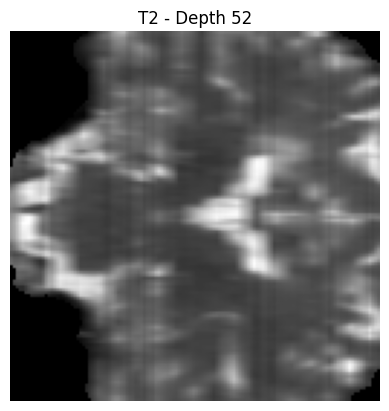

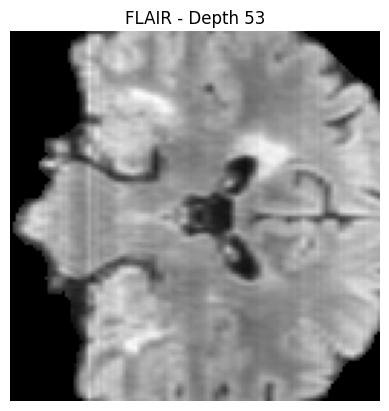

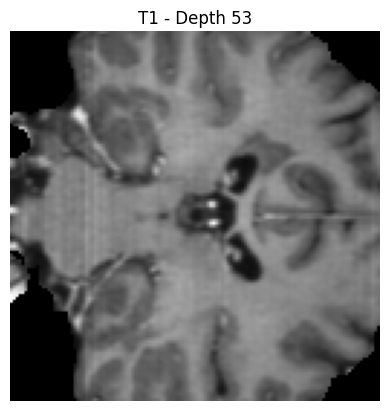

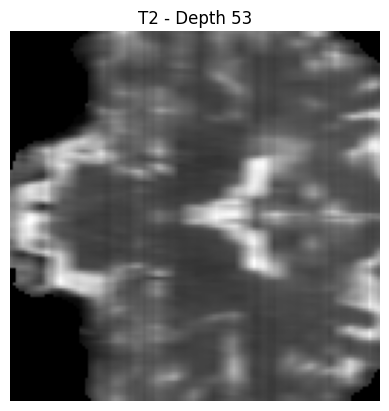

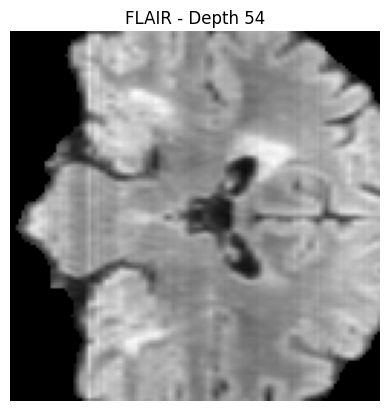

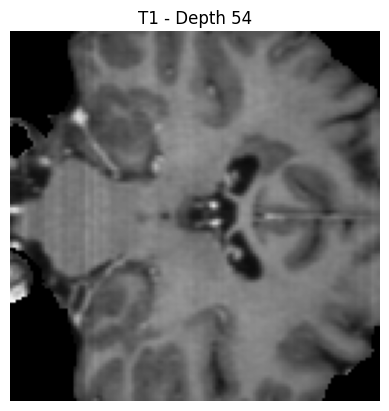

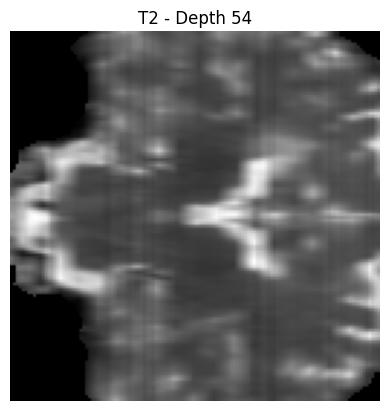

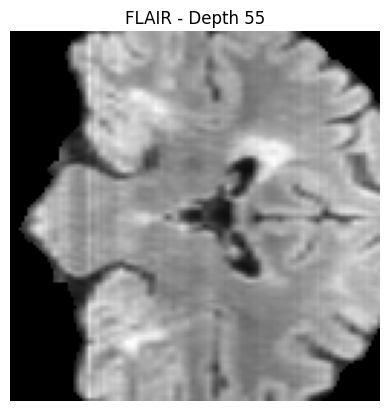

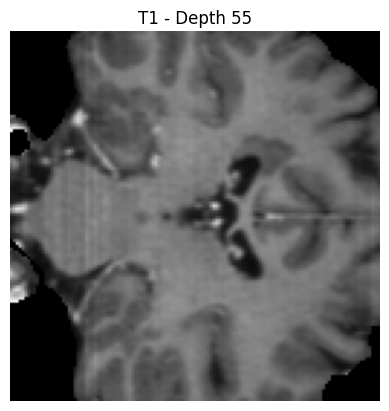

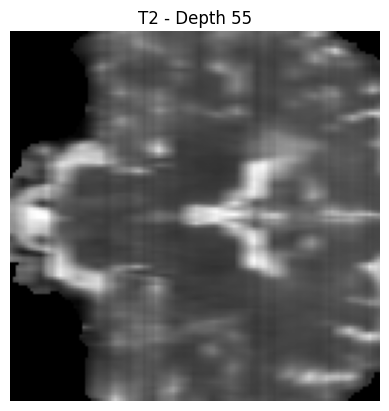

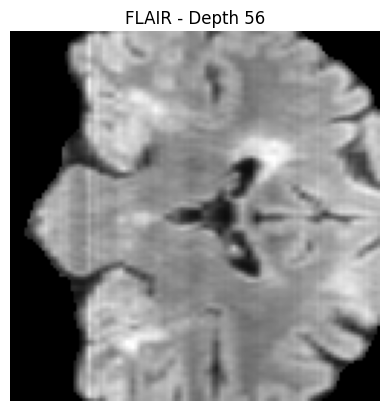

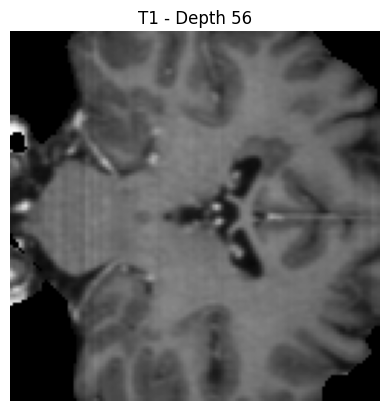

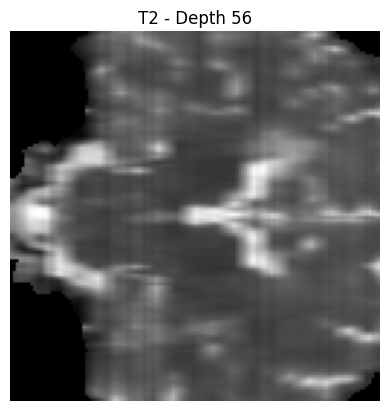

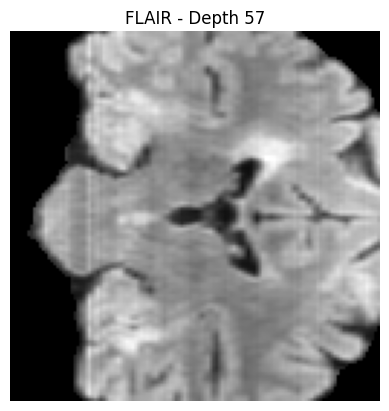

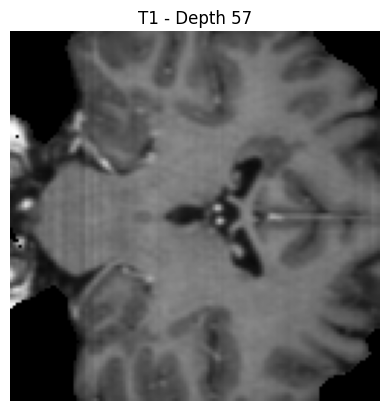

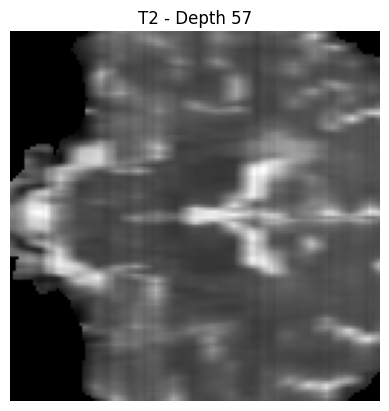

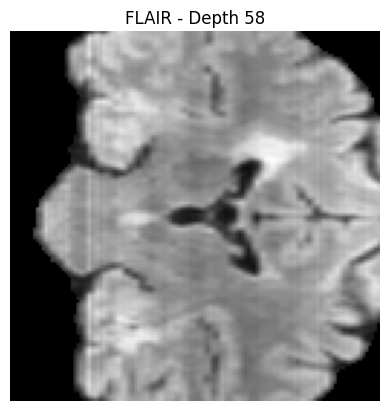

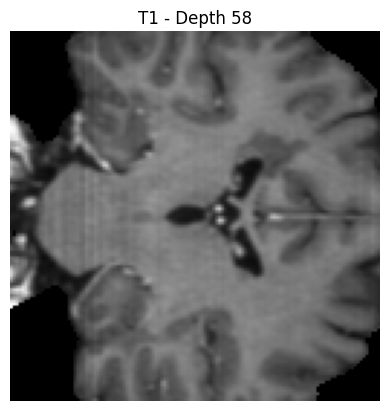

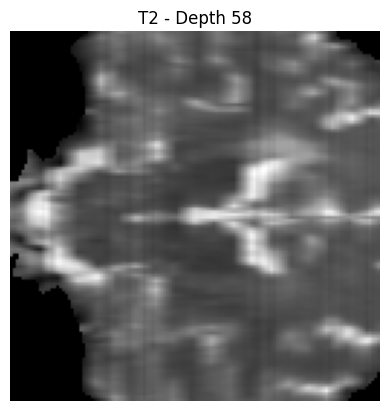

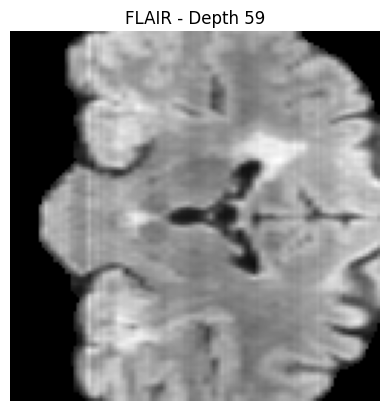

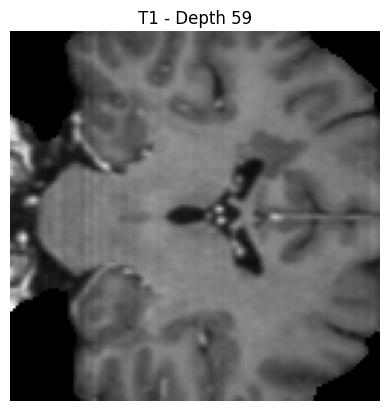

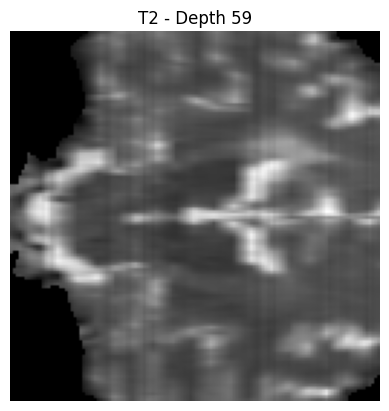

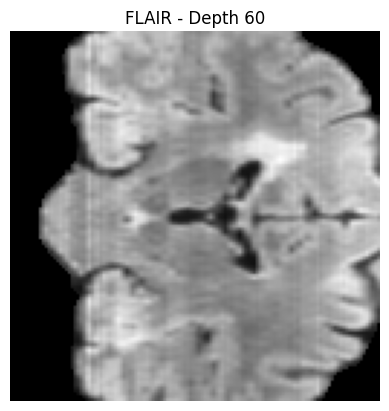

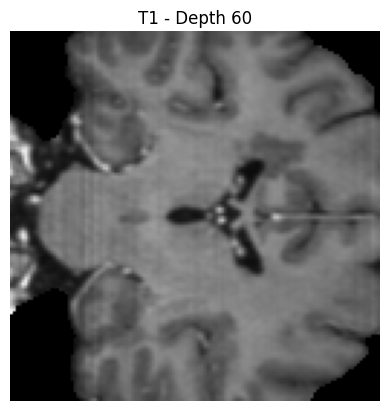

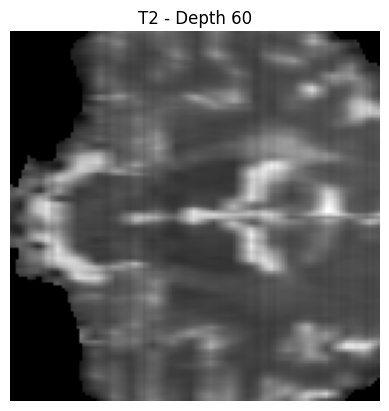

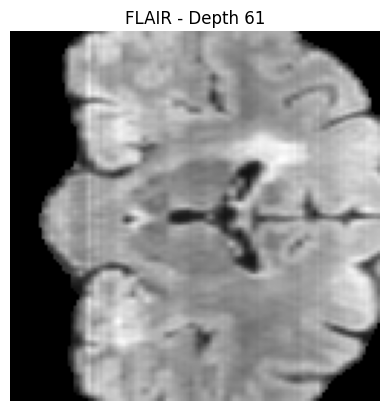

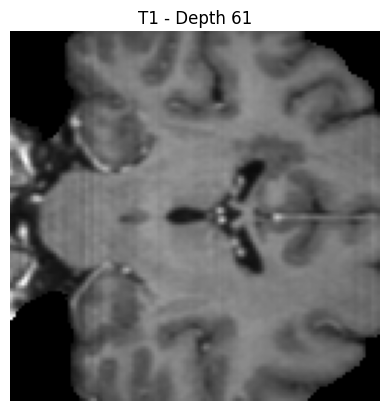

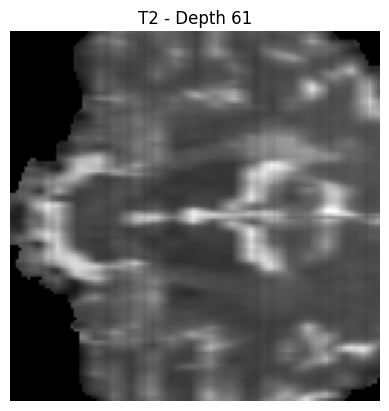

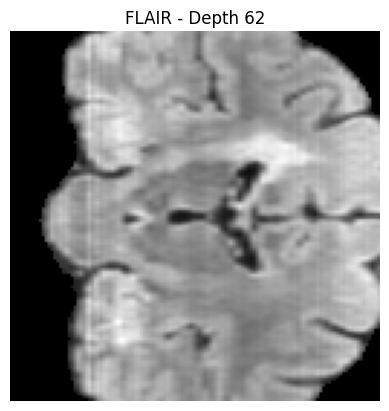

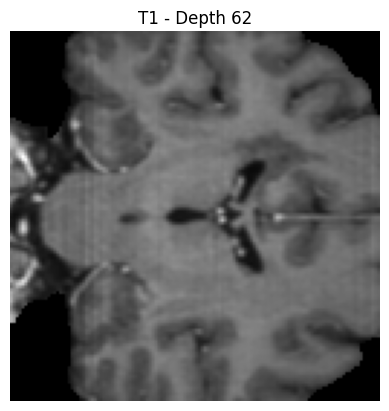

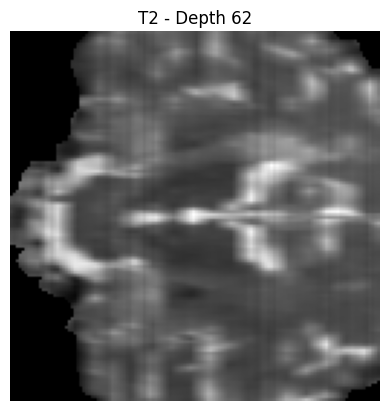

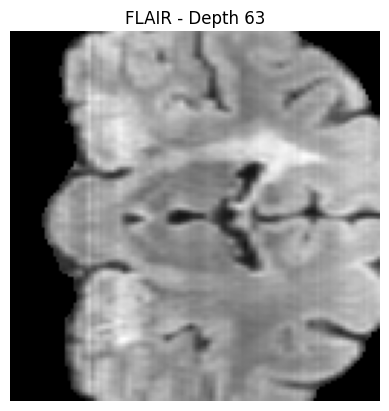

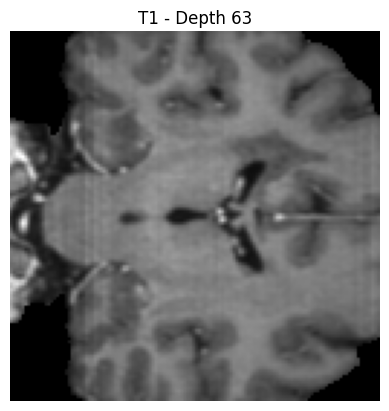

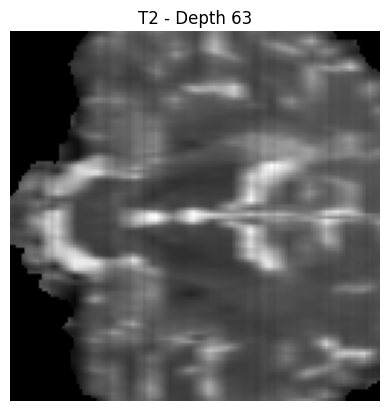

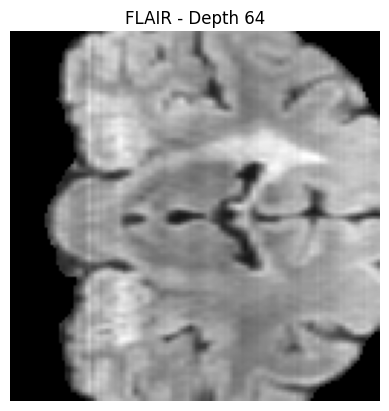

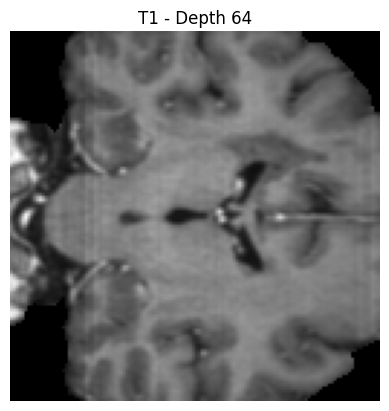

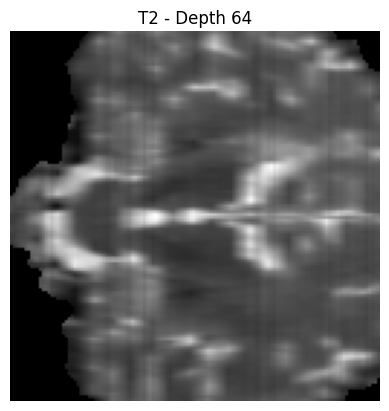

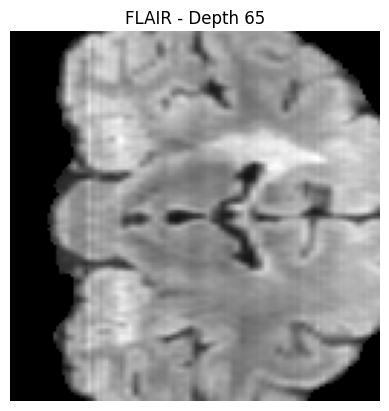

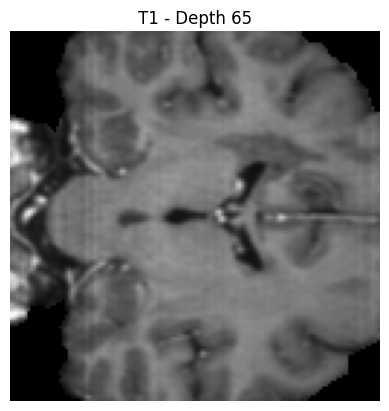

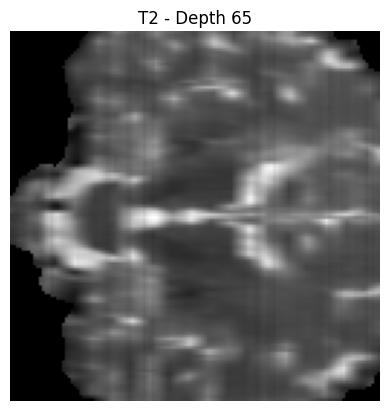

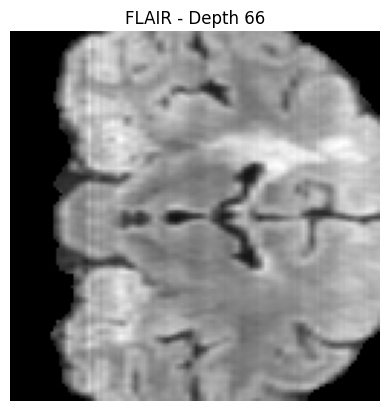

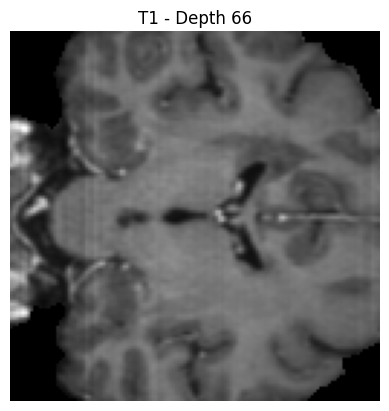

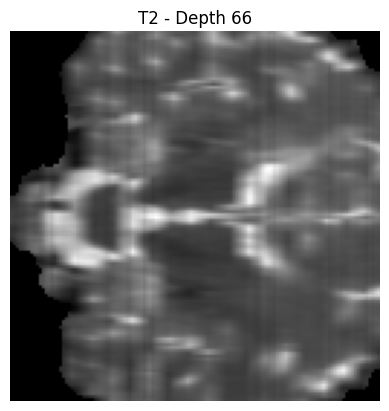

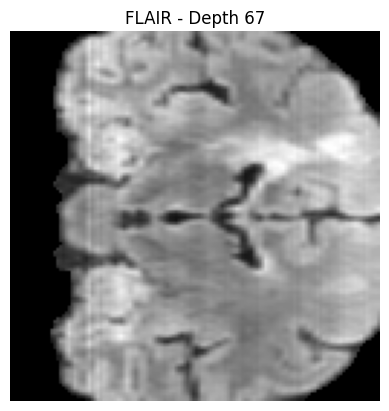

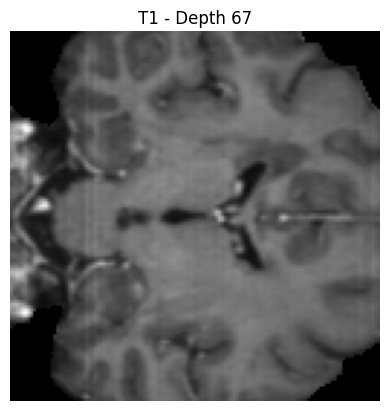

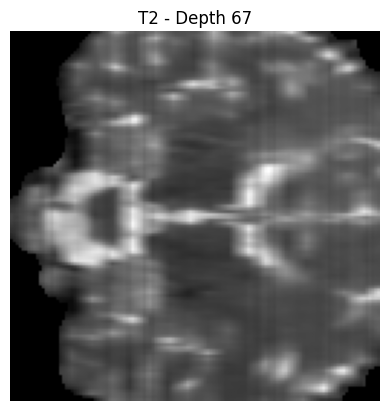

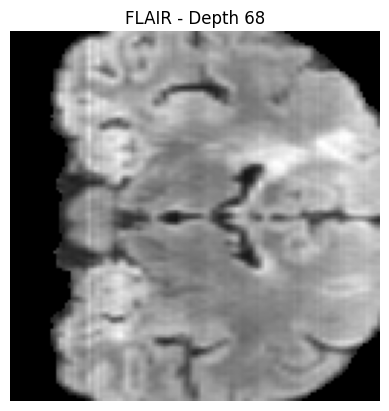

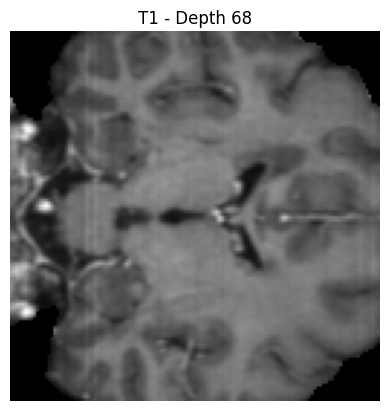

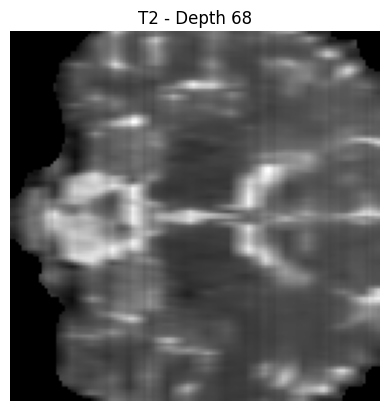

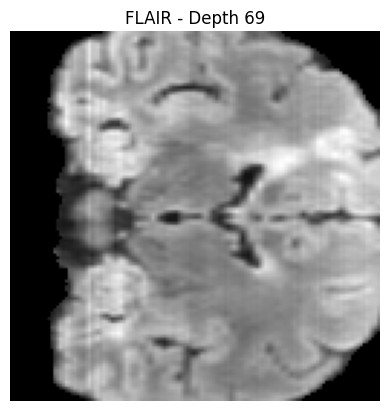

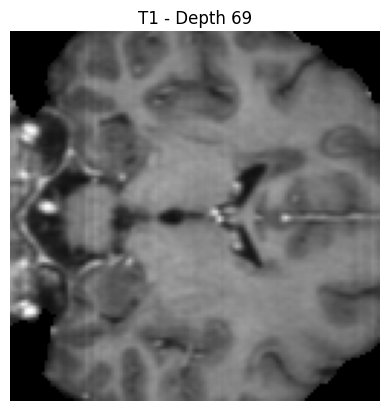

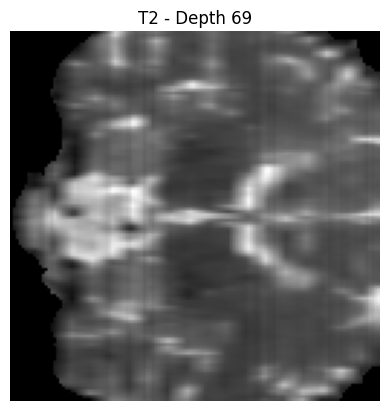

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the tensor is of shape [C, H, D, W] (3, 192, 192, 224)
# C = 3 (modalities), H = Height, D = Depth (number of slices), W = Width

# Select the depth range to visualize
start_depth = 50  # starting slice along depth
end_depth = 70    # ending slice along depth

# Function to display slices
def show_slices(tensor, start_depth, end_depth):
    for depth in range(start_depth, end_depth):
        for channel in range(tensor.shape[0]):  # Loop through modalities (C channels)
            # Extract a slice from a specific modality (channel) and depth
            slice_data = tensor[channel, :, depth, :].cpu().numpy()  # Channel, All Height, Depth, Width
            modality_name = ['FLAIR', 'T1', 'T2'][channel]  # Map channel index to modality name
            plt.imshow(slice_data, cmap='gray')
            plt.title(f"{modality_name} - Depth {depth}")
            plt.axis('off')
            plt.show()

# Display the slices for the selected depth range
show_slices(tensor, start_depth, end_depth)